## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [3]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import unicodedata
import re
from bs4 import BeautifulSoup

# www.topuniversities.com

## Methodology

After examing the webpage, we identify the URL of a JSON file that contains the ranking. Working with JSON is much simpler than working with HTML, so we perform an HTTP GET on that URL, providing a suitable timestamp value (`?_=...`). We then parse the JSON and extract the information we are interested in.

As indicated in the problem statement, some stats are not available in the main list. We visit each university URL to extract the missing stats and scrap the HTML using BeautifulSoup.

Finally, we put all this data in a dataframe.

In [4]:
BASE_URL_TOP = 'https://www.topuniversities.com'
RANKING_URL_TOP = '/sites/default/files/qs-rankings-data/357051.txt?_=%d'

In [5]:
# Helper function to extract a metric using a CSS selector
def extract_metric(soup, selector):
    try:
        return int(soup.select(selector)[0].get_text().replace(',', ''))
    except:
        return None

# Function to obtain and format the top n universities in the ranking
def get_list_top(n=200):
    # Request the JSON data
    timestamp = int(time.time() * 1000)
    r = requests.get((BASE_URL_TOP + RANKING_URL_TOP) % timestamp)
    raw_ranking = r.json()['data'][0:n]
    
    # Process and clean each entry in the ranking, fetching the detailed page and extracting the necessary information
    ranking = []
    for entry in raw_ranking:
        rank = int(entry['rank_display'].replace('=', '')) # drop the = for tied ranks
        name = entry['title']
        country = entry['country']
        region = entry['region']
        r = requests.get(BASE_URL_TOP + entry['url'])
        soup = BeautifulSoup(r.text, 'lxml')
        total_students = extract_metric(soup, 'div.total.student .number')
        total_int_students = extract_metric(soup, 'div.total.inter .number')
        total_faculty = extract_metric(soup, 'div.total.faculty .number')
        total_int_faculty = extract_metric(soup, 'div.inter.faculty .number')
        ranking.append({'rank': rank, 'name': name, 'country': country, 'region': region, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty, 'total_int_faculty': total_int_faculty})        
    
    # Create the dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty', 'total_int_faculty'], axis=1)
    return df
    
# Let's see what it looks like...
top_df = get_list_top()
top_df

,name,country,region,total_students,total_int_students,total_faculty,total_int_faculty
rank,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,3717.0,2982.0,1679.0
2,Stanford University,United States,North America,15878.0,3611.0,4285.0,2042.0
3,Harvard University,United States,North America,22429.0,5266.0,4350.0,1311.0
4,California Institute of Technology (Caltech),United States,North America,2255.0,647.0,953.0,350.0
5,University of Cambridge,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0
6,University of Oxford,United Kingdom,Europe,19720.0,7353.0,6750.0,2964.0
7,UCL (University College London),United Kingdom,Europe,31080.0,14854.0,6345.0,2554.0
8,Imperial College London,United Kingdom,Europe,16090.0,8746.0,3930.0,2071.0
9,University of Chicago,United States,North America,13557.0,3379.0,2449.0,635.0


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [6]:
df = top_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]
df

,name,country,region,total_students,total_int_students,total_faculty,total_int_faculty,faculty_to_students_ratio
rank,,,,,,,,
1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,3717.0,2982.0,1679.0,0.269450
2,Stanford University,United States,North America,15878.0,3611.0,4285.0,2042.0,0.269870
3,Harvard University,United States,North America,22429.0,5266.0,4350.0,1311.0,0.193945
4,California Institute of Technology (Caltech),United States,North America,2255.0,647.0,953.0,350.0,0.422616
5,University of Cambridge,United Kingdom,Europe,18770.0,6699.0,5490.0,2278.0,0.292488
6,University of Oxford,United Kingdom,Europe,19720.0,7353.0,6750.0,2964.0,0.342292
7,UCL (University College London),United Kingdom,Europe,31080.0,14854.0,6345.0,2554.0,0.204151
8,Imperial College London,United Kingdom,Europe,16090.0,8746.0,3930.0,2071.0,0.244251
9,University of Chicago,United States,North America,13557.0,3379.0,2449.0,635.0,0.180645


In [7]:
df = top_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]

,name,int_to_students_ratio
rank,,
35,London School of Economics and Political Scien...,0.691393
12,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
8,Imperial College London,0.543567
200,Maastricht University,0.502533
47,Carnegie Mellon University,0.478062
7,UCL (University College London),0.477928
92,University of St Andrews,0.457955
41,The University of Melbourne,0.427434
127,Queen Mary University of London,0.421816


Answer the previous question aggregating the data by (c) country and (d) region.

In [8]:
country_df = top_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

In [9]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]

,faculty_to_students_ratio
country,
Russia,0.221910
Denmark,0.177261
Saudi Arabia,0.175828
Singapore,0.161530
Malaysia,0.153893
Japan,0.152479
South Korea,0.141721
Switzerland,0.140434
United Kingdom,0.136962


In [10]:
df = country_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

,int_to_students_ratio
country,
Australia,0.352189
United Kingdom,0.341705
Hong Kong,0.310751
Austria,0.309980
Switzerland,0.302396
Singapore,0.276537
Canada,0.260161
New Zealand,0.258215
Ireland,0.235299


In [11]:
region_df = top_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum', 'total_int_faculty': 'sum'})

In [12]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

,faculty_to_students_ratio
region,
Asia,0.132260
North America,0.117776
Europe,0.111564
Latin America,0.104147
Africa,0.088450
Oceania,0.072385


In [13]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

,int_to_students_ratio
region,
Oceania,0.339261
Europe,0.229589
North America,0.188906
Africa,0.169703
Asia,0.136431
Latin America,0.084615


# www.timeshighereducation.com

## Methodology

We also identify the URL of a JSON file that contains the ranking for this dataset and proceed a similar way as for the previous one. It appears that the JSON file contains everything we are interested in, but the number of international faculty and the region. However, since the detailed pages for each university does not contain this information either, there is no point in using BeautifulSoup to extract data from there.

In [14]:
RANKING_URL_TIMES = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

In [15]:
# Function to obtain and format the top n universities in the ranking
def get_list_times(n=200):
    # HTTP GET to fetch the data
    r = requests.get(RANKING_URL_TIMES)
    raw_ranking = r.json()['data']
    
    # Process and clean each entry in the ranking
    ranking = []
    for entry in raw_ranking[0:n]:
        rank = int(entry['rank'].replace('=', '')) # drop the = for tied ranks
        name = entry['name']
        country = entry['location']
        total_students = int(entry['stats_number_students'].replace(',', ''))
        total_int_students = int(float(entry['stats_pc_intl_students'].replace('%', '')) / 100.0 * total_students)
        total_faculty = int(total_students / float(entry['stats_student_staff_ratio']))
        ranking.append({'rank': rank, 'name': name, 'country': country, 'total_students': total_students, 'total_int_students': total_int_students, 'total_faculty': total_faculty})   
    
    # Create a dataframe and index it
    df = pd.DataFrame(ranking)
    df = df.set_index('rank')
    df = df.reindex_axis(['name', 'country', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
    return df

# Let's see what this one looks like
times_df = get_list_times()
times_df

,name,country,total_students,total_int_students,total_faculty
rank,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822
2,University of Cambridge,United Kingdom,18389,6436,1687
3,California Institute of Technology,United States,2209,596,339
3,Stanford University,United States,15845,3485,2112
5,Massachusetts Institute of Technology,United States,11177,3800,1284
6,Harvard University,United States,20326,5284,2283
7,Princeton University,United States,7955,1909,958
8,Imperial College London,United Kingdom,15857,8721,1390
9,University of Chicago,United States,13525,3381,2181


As we can see, that dataframe does not contain the region. However, we can infer the region using the data from the first dataframe.

Let's build a mapping from country to region using the first dataframe...

In [16]:
countries_regions_df = top_df.copy().reset_index().loc[:, ['country', 'region']].drop_duplicates()
# Let's add a couple missing ones
countries_regions_df = pd.concat([countries_regions_df, pd.DataFrame([['Russian Federation', 'Europe'], ['Luxembourg', 'Europe']], columns=['country', 'region'])])

... And join that mapping with the times dataframe to get the region column filled in. 

In [17]:
times_df = times_df.reset_index().merge(countries_regions_df)
times_df['rank'].astype(int)
times_df = times_df.set_index('rank')
times_df.reindex_axis(['name', 'country', 'region', 'total_students', 'total_int_students', 'total_faculty'], axis=1)
times_df = times_df.sort_index()

# Let's see what it looks like...
times_df

,name,country,total_students,total_int_students,total_faculty,region
rank,,,,,,
1,University of Oxford,United Kingdom,20409,7755,1822,Europe
2,University of Cambridge,United Kingdom,18389,6436,1687,Europe
3,Stanford University,United States,15845,3485,2112,North America
3,California Institute of Technology,United States,2209,596,339,North America
5,Massachusetts Institute of Technology,United States,11177,3800,1284,North America
6,Harvard University,United States,20326,5284,2283,North America
7,Princeton University,United States,7955,1909,958,North America
8,Imperial College London,United Kingdom,15857,8721,1390,Europe
9,University of Chicago,United States,13525,3381,2181,North America


Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [18]:
df = times_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'faculty_to_students_ratio']]

,name,faculty_to_students_ratio
rank,,
105,Vanderbilt University,0.302972
109,University of Copenhagen,0.243889
13,Johns Hopkins University,0.232546
12,Yale University,0.232497
153,University of Rochester,0.232462
98,Emory University,0.227212
17,Duke University,0.222208
115,École Polytechnique,0.195784
184,Scuola Normale Superiore di Pisa,0.192233


In [19]:
df = times_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['name', 'int_to_students_ratio']]

,name,int_to_students_ratio
rank,,
25,London School of Economics and Political Science,0.709985
179,University of Luxembourg,0.569934
8,Imperial College London,0.549978
38,École Polytechnique Fédérale de Lausanne,0.549960
103,Maastricht University,0.499970
16,University College London,0.489968
143,University of St Andrews,0.479956
24,Carnegie Mellon University,0.449984
121,Queen Mary University of London,0.449984


Answer the previous question aggregating the data by (c) country and (d) region.

In [20]:
country_df = times_df.copy()
country_df = country_df.groupby('country').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

In [21]:
df = country_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).head(10).loc[:, ['faculty_to_students_ratio']]

,faculty_to_students_ratio
country,
Denmark,0.165278
Russian Federation,0.136954
Japan,0.133331
Italy,0.130290
Switzerland,0.093165
United States,0.089308
Taiwan,0.086939
South Africa,0.085439
China,0.084234


In [22]:
df = times_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).head(10).loc[:, ['int_to_students_ratio']]

,int_to_students_ratio
rank,
25,0.709985
179,0.569934
8,0.549978
38,0.549960
103,0.499970
16,0.489968
143,0.479956
24,0.449984
121,0.449984


In [23]:
region_df = times_df.copy()
region_df = region_df.groupby('region').agg({'total_students': 'sum', 'total_int_students': 'sum', 'total_faculty': 'sum'})

In [24]:
df = region_df.copy()
df['faculty_to_students_ratio'] = df['total_faculty'] / df['total_students']
df.sort_values('faculty_to_students_ratio', ascending=False).loc[:, ['faculty_to_students_ratio']]

,faculty_to_students_ratio
region,
Africa,0.085439
North America,0.084685
Asia,0.080286
Europe,0.059160
Oceania,0.038635


In [25]:
df = region_df.copy()
df['int_to_students_ratio'] = df['total_int_students'] / df['total_students']
df.sort_values('int_to_students_ratio', ascending=False).loc[:, ['int_to_students_ratio']]

,int_to_students_ratio
region,
Oceania,0.309745
Europe,0.224634
Africa,0.179976
North America,0.171996
Asia,0.148464


# Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

We observe that university names can differ quite significantly between each ranking, so we opt for the following merging strategy:

1. Merge the two dataframes by country and region, effectively computing a filtered cartesian product of the two rankings.
2. Use a string similarity metric to estimate the similarity between the names in each ranking. We remove common words such as _University_, _of_, etc. to avoid confusing the metric.
3. Sort entries by decreasing similarity and pick one entry for each university name.
4. Filter out matchings with low similarity. We opt for a similarity of >= 0.8 after careful examination of the results.

In [26]:
from difflib import SequenceMatcher

def clean_name(name):
    tmp = name
    for token in ['University', 'of', 'Institute', 'The', 'Technology']:
        tmp = tmp.replace(token, '')
    return tmp.strip()

def similar(n1, n2):
    return SequenceMatcher(None, clean_name(n1), clean_name(n2)).ratio()

In [27]:
SIMILARITY_CUT = 0.8

In [28]:
df1 = top_df.copy()
df1 = df1.reset_index()
df2 = times_df.copy()
df2.loc[df2.country == 'Russian Federation', 'country'] = 'Russia' # Adjust Russia's name
df2 = df2.reset_index()

# Merge both dataframes on country and region
df = df1.merge(df2, on=['country', 'region'], suffixes=['_top', '_times'])

# Compute similarity
df['similarity'] = df[['name_top','name_times']].apply(lambda x: similar(*x), axis=1)

# Select each unique entry with the highest similarity, then filter out entries with too low similarity
merged_df = df.sort_values('similarity', ascending=False).groupby('name_times', as_index=False).first()
merged_df = merged_df.loc[merged_df.similarity >= SIMILARITY_CUT]

# Clean it up a little...
merged_df = merged_df[['name_times', 'country', 'region', 'rank_top', 'rank_times', 'total_students_top', 'total_int_students_top', 'total_faculty_top', 'total_int_faculty', 'total_students_times', 'total_int_students_times', 'total_faculty_times']].rename(columns = {'name_times':'name'})
merged_df = merged_df.set_index('name')
merged_df = merged_df.sort_index()

# Let's see what that looks like
merged_df

,country,region,rank_top,rank_times,total_students_top,total_int_students_top,total_faculty_top,total_int_faculty,total_students_times,total_int_students_times,total_faculty_times
name,,,,,,,,,,,
Aalto University,Finland,Europe,137,190,12147.0,1831.0,1257.0,370.0,12744,2548,630
Aarhus University,Denmark,Europe,119,109,26226.0,3762.0,2316.0,602.0,25167,3020,1759
Australian National University,Australia,Oceania,20,48,14442.0,5551.0,1600.0,927.0,15986,5595,828
Boston University,United States,North America,81,70,25662.0,7041.0,3157.0,379.0,24833,6208,2887
Brown University,United States,North America,53,50,9251.0,1825.0,1303.0,379.0,8898,1779,831
Cardiff University,United Kingdom,Europe,137,162,24565.0,6090.0,2755.0,705.0,24186,6288,1791
Carnegie Mellon University,United States,North America,47,24,13356.0,6385.0,1342.0,425.0,12676,5704,938
Chinese University of Hong Kong,Hong Kong,Asia,46,58,18037.0,4824.0,2208.0,1074.0,18072,5602,1044
City University of Hong Kong,Hong Kong,Asia,49,119,9240.0,3273.0,1349.0,1027.0,9240,3234,825


It appears our merging strategy managed to match 142 university names. Not bad...

# Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

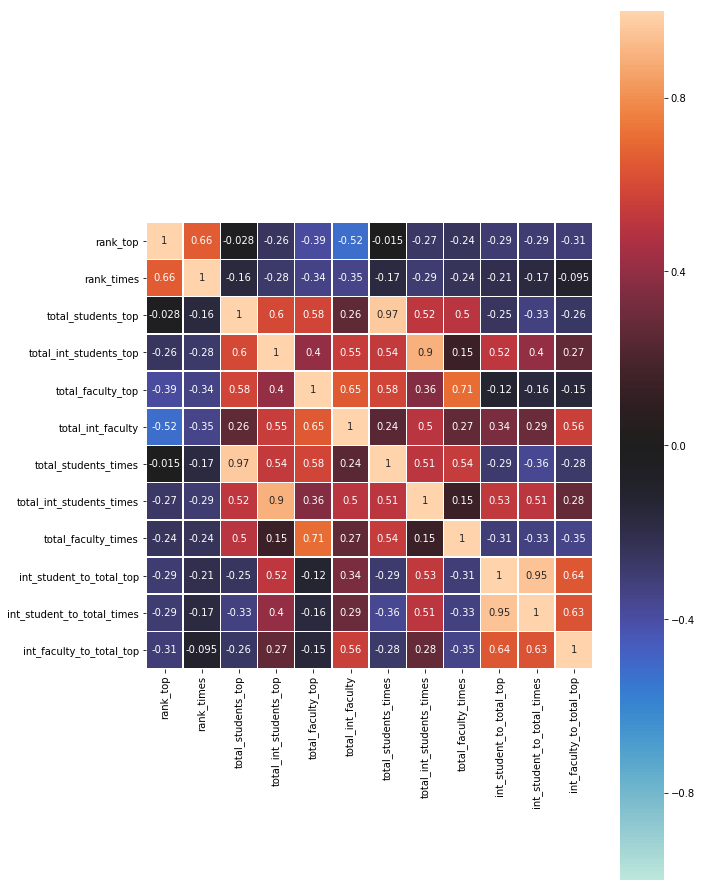

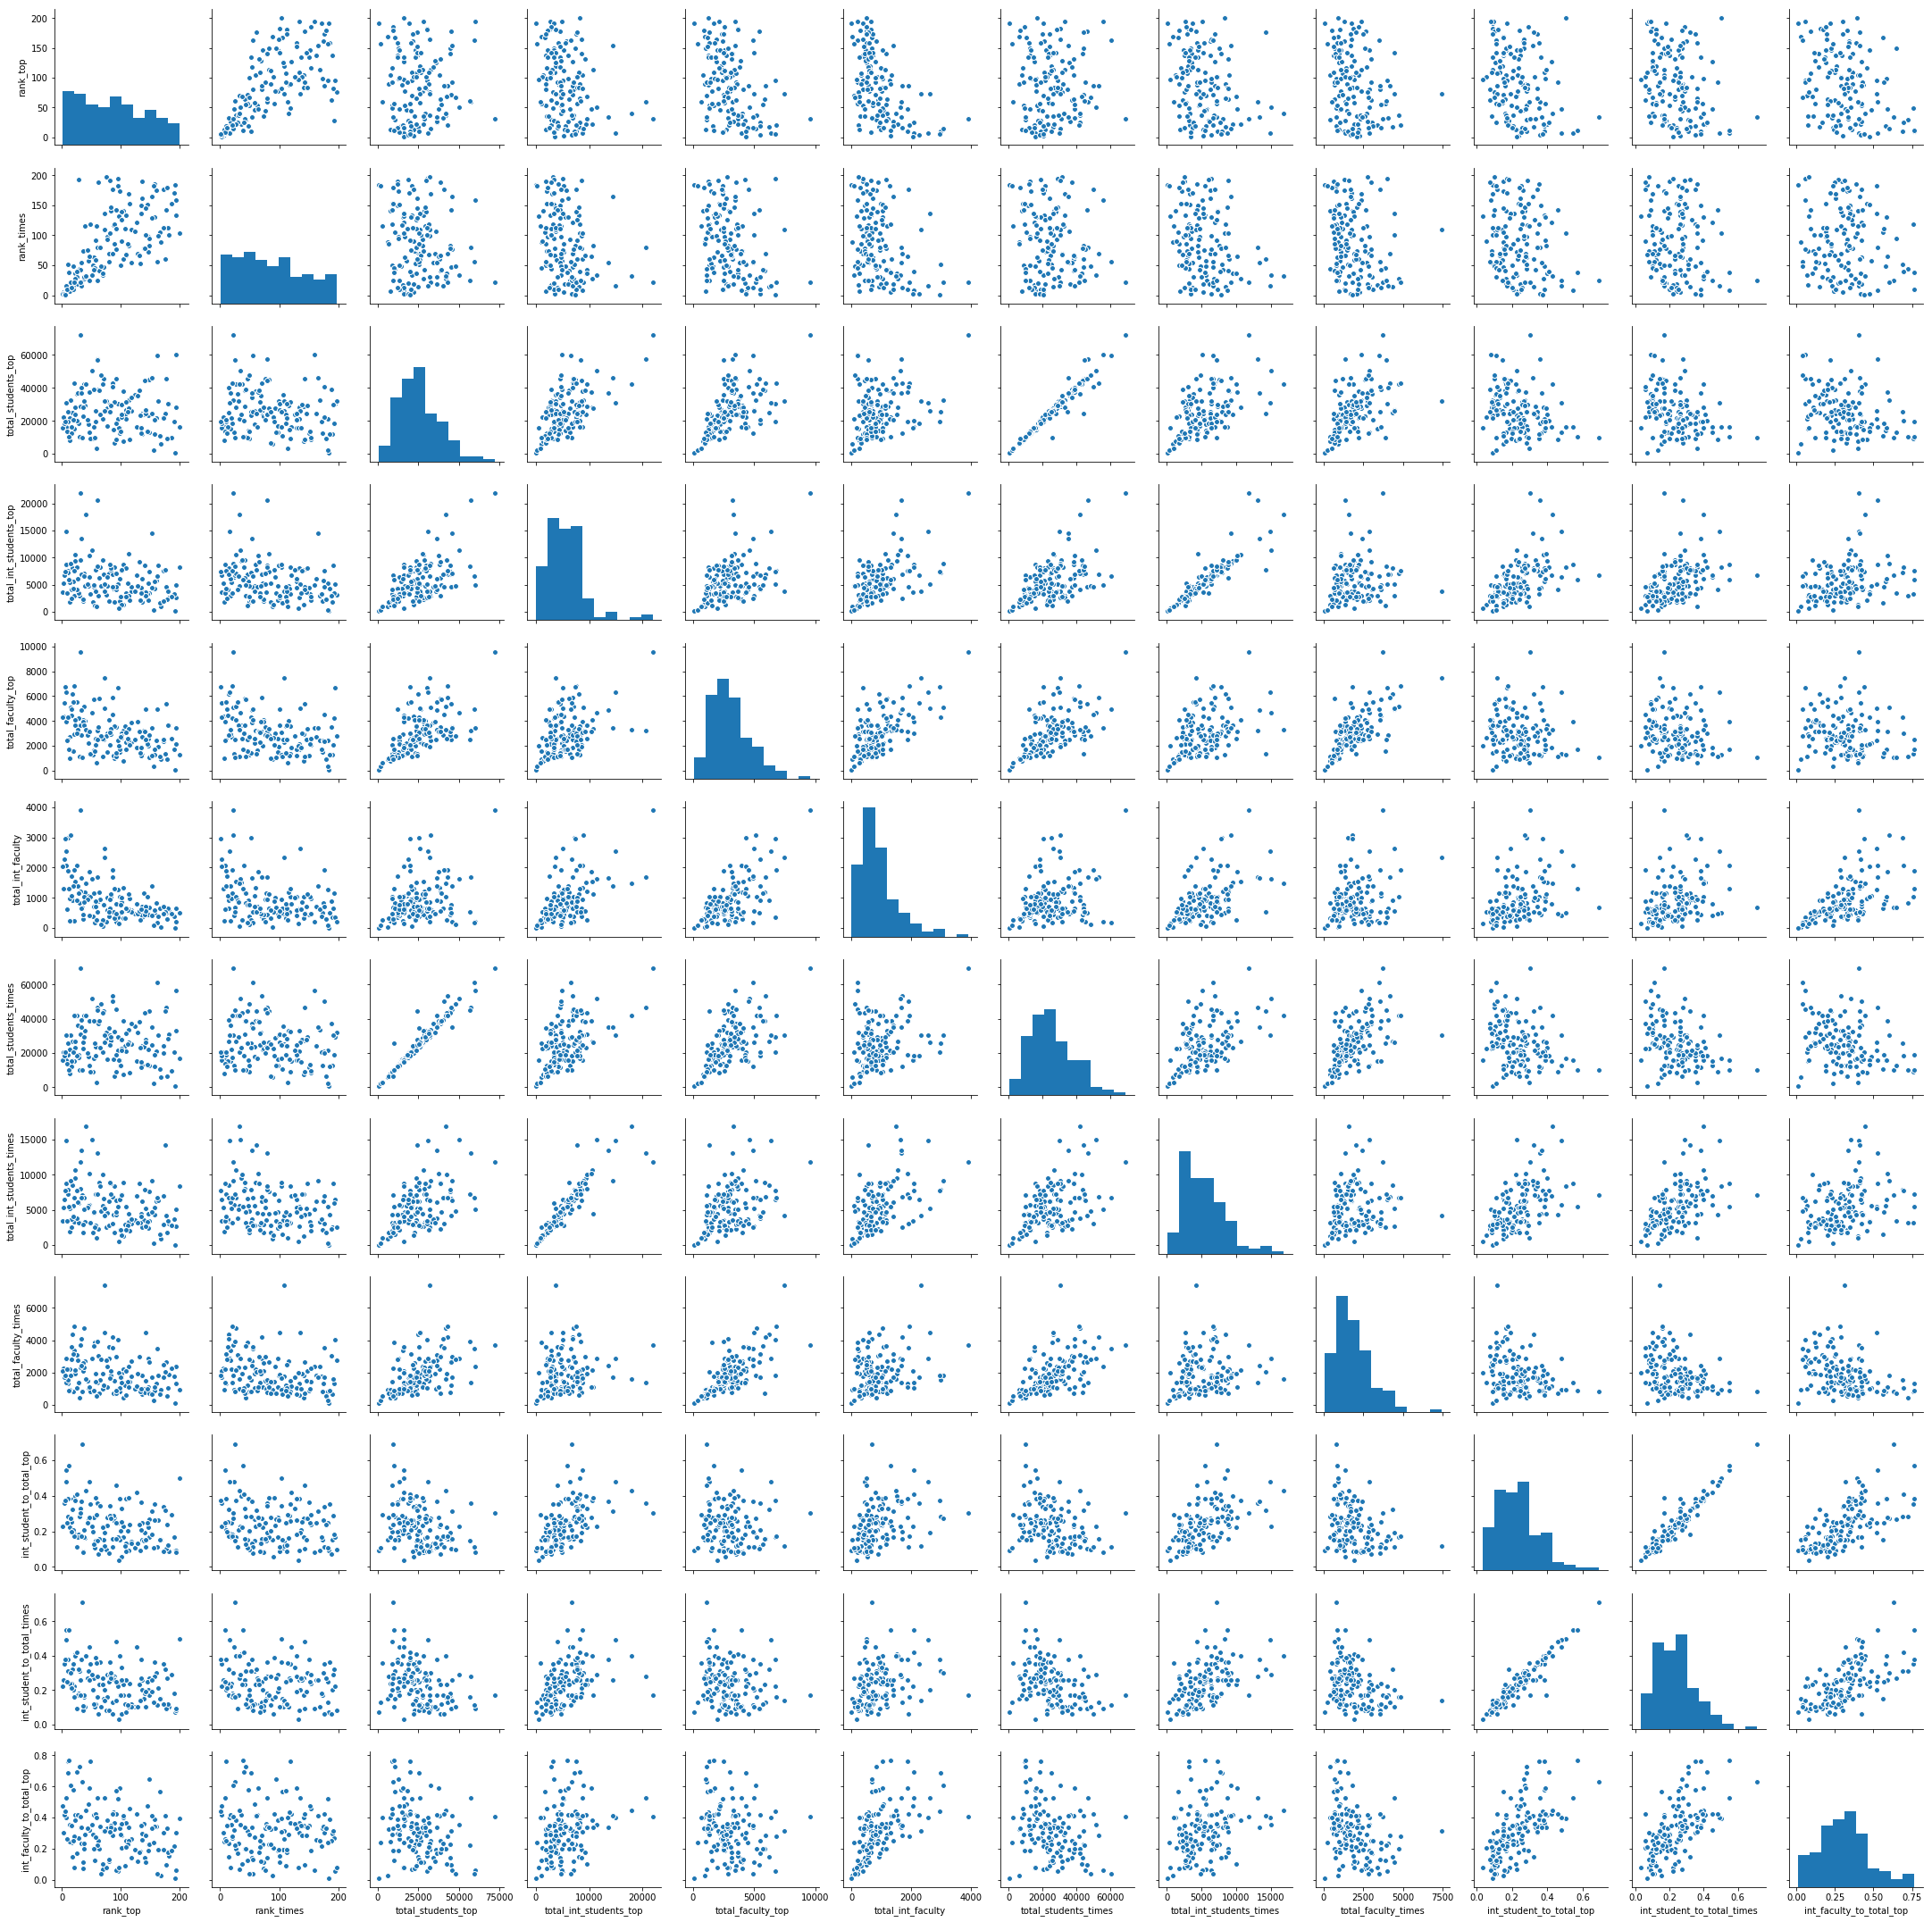

,rank_top,rank_times,total_students_top,total_int_students_top,total_faculty_top,total_int_faculty,total_students_times,total_int_students_times,total_faculty_times,int_student_to_total_top,int_student_to_total_times,int_faculty_to_total_top
rank_top,NaN,0.658637,NaN,NaN,NaN,-0.522160,NaN,NaN,NaN,NaN,NaN,NaN
rank_times,0.658637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_students_top,NaN,NaN,NaN,0.599842,0.584854,NaN,0.966437,0.515636,0.501709,NaN,NaN,NaN
total_int_students_top,NaN,NaN,0.599842,NaN,NaN,0.554336,0.538432,0.897057,NaN,0.521703,NaN,NaN
total_faculty_top,NaN,NaN,0.584854,NaN,NaN,0.648756,0.582541,NaN,0.709338,NaN,NaN,NaN
total_int_faculty,-0.522160,NaN,NaN,0.554336,0.648756,NaN,NaN,0.501840,NaN,NaN,NaN,0.557299
total_students_times,NaN,NaN,0.966437,0.538432,0.582541,NaN,NaN,0.508606,0.541148,NaN,NaN,NaN
total_int_students_times,NaN,NaN,0.515636,0.897057,NaN,0.501840,0.508606,NaN,NaN,0.528932,0.513659,NaN
total_faculty_times,NaN,NaN,0.501709,NaN,0.709338,NaN,0.541148,NaN,NaN,NaN,NaN,NaN
int_student_to_total_top,NaN,NaN,NaN,0.521703,NaN,NaN,NaN,0.528932,NaN,NaN,0.949138,0.641781


In [80]:
df_ratio = merged_df.copy()
df_ratio['int_student_to_total_top'] = df_ratio['total_int_students_top']/df_ratio['total_students_top']
df_ratio['int_student_to_total_times'] = df_ratio['total_int_students_times']/df_ratio['total_students_times']

df_ratio['int_faculty_to_total_top'] = df_ratio['total_int_faculty']/df_ratio['total_faculty_top']

# Calculation of correlation

df_ratio
correlations = df_ratio.corr()
# Keep correlations smaller than 1 and abs(correlations) > 0.5
strong_correlations = correlations[((correlations >= 0.5) | (correlations <= -0.5)) & (correlations < 1)]
# Keep correlations smaller than 0.5 and abs(correlations) > 0.3
moderate_correlations = correlations[((correlations >= 0.3) | (correlations <= -0.3)) & (correlations < 0.5)]
# Keep correlations smaller than 0.3 and abs(correlations) > 0.1
weak_correlations = correlations[((correlations >= 0.1) | (correlations <= -0.1)) & (correlations < 0.3)]

strong_correlations

# correlation for pairs

rank_top_strong_correlations = strong_correlations['rank_top'].dropna()
rank_times_strong_correlations = strong_correlations['rank_times'].dropna()
strong_correlations

plt.figure(figsize=(10, 16))
sns.heatmap(correlations, annot=True, center =0,square=True,linewidths=.5, vmax = 1.0, vmin = -1.0)

sns.pairplot(df_ratio)
plt.show()
strong_correlations

# Can you find the best university taking in consideration both rankings? Explain your approach.